In [11]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
max_seq_len = 100
max_vocab_size = 20000
embedding_dim = 100
validation_split = 0.2
batch_size = 128
epochs = 10

In [3]:
word_embeddings = {}
with open(os.path.join('embeddings/glove.6B/glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word_key = values[0]
        word_vector = np.array(values[1:], dtype='float32')
        
        word_embeddings[word_key] = word_vector

In [29]:
len(word_embeddings)

400000

In [8]:
train_df = pd.read_csv('data/jigsaw-toxic-comment-classification-challenge/train.csv')
train_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [9]:
documents = train_df.comment_text.fillna('Dummy_Value').values
targets = train_df[train_df.columns[2:]].values

In [10]:
doc_len_list = [len(d) for d in documents]
max_doc_len = max(doc_len_list)
min_doc_len = min(doc_len_list)
avg_doc_len = sum(doc_len_list)/len(documents)

print(f'max document length: {max_doc_len}')
print(f'min document length: {min_doc_len}')
print(f'Avg document length: {avg_doc_len}')

max document length: 5000
min document length: 6
Avg document length: 394.0732213246768


<function matplotlib.pyplot.show(close=None, block=None)>

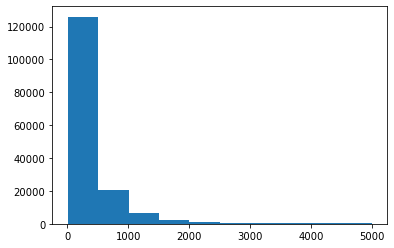

In [13]:
plt.hist(doc_len_list)
plt.show

In [15]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(documents)
sequences = tokenizer.texts_to_sequences(documents)

In [19]:
word_index = tokenizer.word_index
len(word_index)

210337

In [21]:
seq_data = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_seq_len)
seq_data.shape

(159571, 100)

In [22]:
seq_data

array([[    0,     0,     0, ...,  4583,  2273,   985],
       [    0,     0,     0, ...,   589,  8377,   182],
       [    0,     0,     0, ...,     1,   737,   468],
       ...,
       [    0,     0,     0, ...,  3509, 13675,  4528],
       [    0,     0,     0, ...,   151,    34,    11],
       [    0,     0,     0, ...,  1627,  2056,    88]], dtype=int32)

In [23]:
num_words = min(max_vocab_size, len(word_index)+1)
num_words

20000

In [27]:
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, idx in word_index.items():
    if idx < max_vocab_size:
        embedding_vector = word_embeddings.get(word)
        
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

In [28]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
         0.47646999, -0.15983   ],
       ...,
       [-1.04809999, -0.32789999, -0.46593001, ..., -0.065447  ,
        -0.13019   ,  0.44433001],
       [ 0.089782  , -0.33164999, -0.85716999, ..., -0.15765999,
        -0.58174002,  0.036233  ],
       [ 0.051446  , -0.43564001,  0.26989001, ...,  0.39087   ,
        -0.14459001, -0.72372001]])

In [31]:
print(f'shape of the seq_data: {seq_data.shape}')
print(f'shape of the targets: {targets.shape}')
print(f'shape of the embedding_matrix: {embedding_matrix.shape}')

shape of the seq_data: (159571, 100)
shape of the targets: (159571, 6)
shape of the embedding_matrix: (20000, 100)


In [32]:
embedding_layer = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False)